In [507]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
import itertools
import nltk
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from autocorrect import Speller
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,RandomizedSearchCV,KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
from contractions import CONTRACTION_MAP
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [508]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [509]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1


In [510]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [511]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


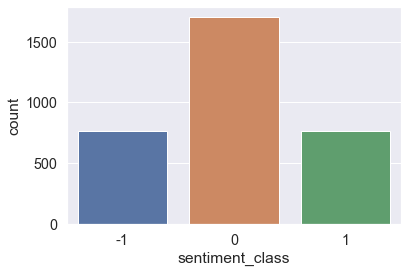

In [512]:
sns.countplot(x='sentiment_class',data=train_data)

In [513]:
train_data['retweet_count']=train_data['retweet_count'].astype(str)
test_data['retweet_count']=test_data['retweet_count'].astype(str)

In [514]:
train_data["retweet_count"]= train_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
train_data["retweet_count"]= train_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [515]:
test_data["retweet_count"]= test_data["retweet_count"].str.replace(r"[a-zA-Z$@#&*!''-/]",'')
test_data["retweet_count"]= test_data["retweet_count"].replace(r'^\s*$', np.nan, regex=True)

In [516]:
train_data['retweet_count']=pd.to_numeric(train_data['retweet_count'])
test_data['retweet_count']=pd.to_numeric(test_data['retweet_count'])

In [517]:
train_data.loc[train_data["retweet_count"]<0,'retweet_count']=0
train_data.loc[train_data["retweet_count"].isna(),'retweet_count']=0
test_data.loc[test_data["retweet_count"]<0,'retweet_count']=0
test_data.loc[test_data["retweet_count"].isna(),'retweet_count']=0
train_data.loc[train_data["retweet_count"]>1000,'retweet_count']=1000
test_data.loc[test_data["retweet_count"]>1000,'retweet_count']=1000

In [518]:
train_data["retweet_count"]=train_data["retweet_count"].astype(int)
test_data["retweet_count"]=test_data["retweet_count"].astype(int)

In [519]:
train_data['lang'].value_counts()

en                            2994
 pink Peruvian opal! via      4   
 Find More                    2   
&gt                           2   
WORLDS OKAYEST MOTHER! &lt    2   
                             ..   
0.5361733802                  1   
0.4344231372                  1   
-0.6792288222                 1   
-0.7798220898                 1   
0.4479350131                  1   
Name: lang, Length: 232, dtype: int64

In [520]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [521]:
train_data['original_text']=train_data['original_text'].apply(expand_contractions)
test_data['original_text']=test_data['original_text'].apply(expand_contractions)

In [522]:
## Number of words in the original_text ##
train_data["num_words"] = train_data["original_text"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["original_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the original_text ##
train_data["num_unique_words"] = train_data["original_text"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["original_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the original_text ##
train_data["num_chars"] = train_data["original_text"].apply(lambda x: len(str(x)))
test_data["num_chars"] = test_data["original_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the original_text ##
train_data["num_stopwords"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_data["num_stopwords"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the original_text ##
train_data["num_punctuations"] =train_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_data["num_punctuations"] =test_data['original_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the original_text ##
train_data["num_words_upper"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_data["num_words_upper"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the original_text ##
train_data["num_words_title"] = train_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_data["num_words_title"] = test_data["original_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the original_text ##
train_data["mean_word_len"] = train_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data["mean_word_len"] = test_data["original_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [523]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it is hard not being able to see your mothers today but it is on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0,45,37,254,27,7,1,2,4.666667
1,1.245759e+18,Happy Mothers Day Mum - I am sorry I cannot be there to bring you Mothers day flowers & a cwtch - honestly at this point I would walk on hot coals to be able to. But I will be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0,63,50,309,28,16,5,12,3.920635
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1,51,47,298,20,11,1,8,4.862745
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0,18,17,155,6,8,0,1,7.666667
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1,42,37,254,15,8,1,7,5.071429


In [524]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def split_words(self,input_text):
        return ''.join(re.findall('[A-Z][^A-Z]*', input_text))
    
    def standardize_words(self,input_text):
        return ''.join(''.join(s)[:2] for _, s in itertools.groupby(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    '''def correct_spell(self,input_text):
        words = input_text.split() 
        clean_words = [str(TextBlob(word).correct()) for word in words] 
        return " ".join(clean_words)'''
    
    """def correct_spell(self,input_text):
        words = input_text.split() 
        spell = Speller(lang='en') 
        correct_words = [spell(word) for word in words] 
        return " ".join(correct_words) """
    '''def remove_meaningless(self,input_text):
        words = set(nltk.corpus.words.words())
        return " ".join(w for w in nltk.wordpunct_tokenize(input_text) if w.lower() in words or not w.isalpha())'''
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.split_words).apply(self.standardize_words).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [525]:
ct = CleanText()
train_data['original_text'] = ct.fit_transform(train_data.original_text)
test_data['original_text']=ct.fit_transform(test_data.original_text)

In [526]:
def clean_text(text_df):
    text_df["clean_text"]= text_df["original_text"].str.replace("mum", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mom", "mother", case = False)
    text_df["clean_text"]= text_df["clean_text"].str.replace("mothersday","mother day") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("httpswww","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("http","") 
    text_df["clean_text"]= text_df["clean_text"].str.replace("u","") 
    return text_df

In [527]:
train_df=clean_text(train_data)
test_df=clean_text(test_data)

In [528]:
tokenizer = nltk.WordPunctTokenizer()
def pos_tagger(input_text):
    text = tokenizer.tokenize(input_text)
    tagged_text = nltk.pos_tag(text)
    new_text = ""
    for tag in tagged_text:
        new_text = new_text + " " + tag[1]
    return new_text

In [529]:
train_df['pos_text'] = train_df['clean_text'].apply(pos_tagger)
test_df['pos_text'] = test_df['clean_text'].apply(pos_tagger)

In [530]:
def stemming(input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
def lemmatize_text(input_text):
        word_list = nltk.word_tokenize(input_text)
        lemmatizer = WordNetLemmatizer() 
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

        return lemmatized_output

In [531]:
train_df['clean_text'] = train_df['clean_text'].apply(stemming)
test_df['clean_text'] = test_df['clean_text'].apply(stemming)

In [532]:
train_df['clean_text'] = train_df['clean_text'].apply(lemmatize_text)
test_df['clean_text'] = test_df['clean_text'].apply(lemmatize_text)

In [533]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [534]:
y = train_df.sentiment_class
X = train_df.drop(['id','original_text','sentiment_class','lang','original_author'],axis=1)

In [535]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [536]:
test_df_id=test_df.id
test_df.drop(['id','original_text','lang','original_author'],axis=1,inplace=True)

In [537]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [538]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [539]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [540]:
### Fit transform the count vectorizer ###
cv_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))
cv_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_cv = cv_vec.transform(train_df['clean_text'].values.tolist())
test_cv = cv_vec.transform(test_df['clean_text'].values.tolist())

In [541]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_cv[dev_index], train_cv[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_cv)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [542]:
# add the predictions as new features #
train_df["nb_cv_sent_pos"] = pred_train[:,0]
train_df["nb_cv_sent_neu"] = pred_train[:,1]
train_df["nb_cv_sent_neg"] = pred_train[:,2]
test_df["nb_cv_sent_pos"] = pred_full_test[:,0]
test_df["nb_cv_sent_neu"] = pred_full_test[:,1]
test_df["nb_cv_sent_neg"] = pred_full_test[:,2]

In [543]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [544]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [545]:
# add the predictions as new features #
train_df["nb_tfidf_char_pos"] = pred_train[:,0]
train_df["nb_tfidf_char_neu"] = pred_train[:,1]
train_df["nb_tfidf_char_neg"] = pred_train[:,2]
test_df["nb_tfidf_char_pos"] = pred_full_test[:,0]
test_df["nb_tfidf_char_neu"] = pred_full_test[:,1]
test_df["nb_tfidf_char_neg"] = pred_full_test[:,2]

In [546]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['clean_text'].values.tolist() + test_df['clean_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['clean_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['clean_text'].values.tolist())

In [547]:
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y

In [548]:
# add the predictions as new features #
train_df["nb_cvec_char_pos"] = pred_train[:,0]
train_df["nb_cvec_char_neu"] = pred_train[:,1]
train_df["nb_cvec_char_neg"] = pred_train[:,2]
test_df["nb_cvec_char_pos"] = pred_full_test[:,0]
test_df["nb_cvec_char_neu"] = pred_full_test[:,1]
test_df["nb_cvec_char_neg"] = pred_full_test[:,2]

In [549]:
min_max_scaler = MinMaxScaler()
train_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=train_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
train_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(train_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])
test_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']]=test_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']].values.astype(float)
test_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']] = min_max_scaler.fit_transform(test_df[['nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']])

In [550]:
y = train_df.sentiment_class
X = train_df.drop(['id','original_text','sentiment_class','lang','original_author'],axis=1)

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [552]:
X_train.columns

Index(['retweet_count', 'num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len', 'clean_text', 'pos_text',
       'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4',
       'svd_char_5', 'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
       'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13',
       'svd_char_14', 'svd_char_15', 'svd_char_16', 'svd_char_17',
       'svd_char_18', 'svd_char_19', 'nb_cv_sent_pos', 'nb_cv_sent_neu',
       'nb_cv_sent_neg', 'nb_tfidf_char_pos', 'nb_tfidf_char_neu',
       'nb_tfidf_char_neg', 'nb_cvec_char_pos', 'nb_cvec_char_neu',
       'nb_cvec_char_neg'],
      dtype='object')

In [553]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def gen_model_features(vect=None, is_w2v=None):
    
    textcountscols = ['num_words','num_unique_words','num_chars','num_stopwords'
                      ,'num_punctuations','num_words_upper','num_words_title','mean_word_len',
                      'nb_cv_sent_pos','nb_cv_sent_neg','nb_cv_sent_neu',"nb_tfidf_char_pos","nb_tfidf_char_neu",
                      "nb_tfidf_char_neg","nb_cvec_char_pos","nb_cvec_char_neu","nb_cvec_char_neg",
                     'svd_char_0', 'svd_char_1', 'svd_char_2', 'svd_char_3', 'svd_char_4','svd_char_5', 
                      'svd_char_6', 'svd_char_7', 'svd_char_8', 'svd_char_9',
                    'svd_char_10', 'svd_char_11', 'svd_char_12', 'svd_char_13','svd_char_14', 'svd_char_15', 
                      'svd_char_16', 'svd_char_17','svd_char_18', 'svd_char_19']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 ,('pipe1', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))         
                                                     ,('vect', vect)])),
                                ('pipe2', Pipeline([('postext', ColumnExtractor(cols='pos_text'))         
                                                     ,('vect', vect)]))]
                                , n_jobs=-1)
    return features

def grid_vect(clf, parameters_clf, X_train, X_test, features, parameters_text=None):
    pipeline = Pipeline([('features', features),('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search_model = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5,random_state=42)
    
    print("Performing grid search...")
    grid_search_model.fit(X_train, y_train)
    print("Best CV score: %0.3f" % grid_search_model.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search_model.best_estimator_.get_params()
    #final_model=grid_search_model.best_estimator_
    #final_model.fit(X,y)
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search_model.best_estimator_.score(X_test, y_test))
                 
    return grid_search_model.best_estimator_

In [574]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe1__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe1__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe1__vect__min_df': (1,2,3,4,5),
    'features__pipe2__vect__max_df': (0.5, 0.75, 1.0),
    'features__pipe2__vect__ngram_range': ((1, 1), (1, 2),(1,3),(2,2)),
    'features__pipe2__vect__min_df': (1,2,3,4,5)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.01,0.1, 0.25, 0.5, 0.75),
    'clf__fit_prior' : (True,False)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__fit_intercept': (True,False),
    'clf__class_weight':['balanced',None]
}
parameters_sgd = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l1', 'l2','elasticnet'),
    'clf__max_iter': (10, 25, 50, 75, 100),
    'clf__class_weight':['balanced',None]
}
parameters_svc = {'clf__kernel': ['linear', 'rbf'],
                    'clf__gamma':[0.1,1,10],
                    'clf__C':[0.1,1,0.001,0.0001],
                  'clf__class_weight':['balanced',None]
                 }
parameters_linsvc = {'clf__loss' : ['hinge', 'squared_hinge'],
                    'clf__penalty': ('l1', 'l2'),
                    'clf__class_weight':['balanced',None],
                    'clf__max_iter':[100,500],
                    'clf__C':[0.1,1,0.001,0.0001]
                     
                 }

parameters_gbm = {'clf__loss':['deviance','exponential'],
         'clf__learning_rate': [0.05,0.1],
         'clf__max_depth':[5,10,20],
         'clf__n_estimators': [10,25,50]
        }
parameters_xgb = {'clf__learning_rate':[0.01,0.1],
         'clf__n_estimators':[50,100,500],
         'clf__max_depth':[5,10,15,20],
        'clf__class_weight':['balanced',None],
         'clf__objective':'reg:linear'
        }

In [555]:
best_scores={}
best_models={}
mnb = MultinomialNB()
logreg = LogisticRegression()
sgd=SGDClassifier()
svc=SVC()
linsvc = LinearSVC()
gbm=GradientBoostingClassifier()
xgb_model=xgb.XGBClassifier()

In [556]:
countvect = CountVectorizer()
tfidfvect = TfidfTransformer()
# MultinomialNB
model_features=gen_model_features(countvect)
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_mnb=best_mnb_countvect.predict(X_test)
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
#best_scores['mnb_countvect']=best_mnb_countvect.best_score_
#best_models['mnb_countvect']=best_mnb_countvect
train_pred1=best_mnb_countvect.predict(X_train)
test_pred1=best_mnb_countvect.predict(X_test)
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.9s finished


Best CV score: 0.410
Best parameters set:
	clf__alpha: 0.5
	clf__fit_prior: True
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 2
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.457

Accuracy score of Multinomial naive bayes algorithm -----> 40.62500012229426


In [557]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

(1387,)


In [558]:
test_predictions1=best_mnb_countvect.predict(test_df)
prediction_df1 = pd.DataFrame(columns=['mnb'],data=test_predictions1)

In [559]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_logreg = best_logreg_countvect.predict(X_test)
logreg_score=100*(f1_score(y_test,prediction_logreg,average='weighted'))
#best_scores['logreg_countvect']=best_logreg_countvect.best_score_
#best_models['logreg_countvect']=best_logreg_countvect
train_pred2=best_logreg_countvect.predict(X_train)
test_pred2=best_logreg_countvect.predict(X_test)
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.7s finished


Best CV score: 0.412
Best parameters set:
	clf__C: 0.5
	clf__class_weight: None
	clf__fit_intercept: False
	clf__penalty: 'l2'
	features__pipe1__vect__max_df: 0.5
	features__pipe1__vect__min_df: 4
	features__pipe1__vect__ngram_range: (1, 3)
	features__pipe2__vect__max_df: 1.0
	features__pipe2__vect__min_df: 2
	features__pipe2__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.493

Accuracy score of Log Reg algorithm -----> 38.44765243883883


In [560]:
test_predictions2=best_logreg_countvect.predict(test_df)
prediction_df2 = pd.DataFrame(columns=['lr'],data=test_predictions2)

In [562]:
# GBC
best_gbm_countvect = grid_vect(gbm, parameters_gbm, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_gbm = best_gbm_countvect.predict(X_test)
gbm_score=100*(f1_score(y_test,prediction_gbm,average='weighted'))
#best_scores['gbm_countvect']=best_gbm_countvect.best_score_
#best_models['gbm_countvect']=best_gbm_countvect
#train_pred3=best_gbm_countvect.predict(X_train)
#test_pred3=best_gbm_countvect.predict(X_test)
print("\nAccuracy score of gbc algorithm -----> " + str(gbm_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.6s finished


Best CV score: 0.381
Best parameters set:
	clf__learning_rate: 0.1
	clf__loss: 'deviance'
	clf__max_depth: 10
	clf__n_estimators: 10
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 1
	features__pipe1__vect__ngram_range: (1, 1)
	features__pipe2__vect__max_df: 0.75
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.495

Accuracy score of gbc algorithm -----> 35.527668607701145


In [563]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_gbm_countvect.fit(X,y)
gbm_predictions=best_gbm_countvect.predict(test_df)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=gbm_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [566]:
from sklearn.ensemble import VotingClassifier
countvect_classifier= VotingClassifier(estimators=[('mnb', best_models['mnb_countvect']), ('lr', best_models['logreg_countvect']),
                         ('sgd', best_models['sgd_countvect']), ('svc', best_models['svc_countvect']),
                         ('gbm', best_models['gbm_countvect'])],voting='hard')
countvect_classifier.fit(X_train,y_train)
countvect_classifier_predictions=countvect_classifier.predict(X_test)
countvect_classifier_predictions_score=100*(f1_score(y_test,countvect_classifier_predictions,average='weighted'))
print("\nAccuracy score of Voting Classifier algorithm -----> " + str(countvect_classifier_predictions_score))

KeyError: 'mnb_countvect'

In [ ]:
"""df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),
                      pd.DataFrame(train_pred3),pd.DataFrame(train_pred4)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)
                     ,pd.DataFrame(test_pred4)], axis=1)"""


In [568]:
from xgboost import XGBClassifier

xgb=XGBClassifier()
#xgb.fit(df_train,y_train)
best_xgb_countvect = grid_vect(xgb, parameters_xgb, X_train, X_test,model_features, parameters_text=parameters_vect)
prediction_xgb = best_xgb_countvect.predict(X_test)
train_pred3=best_xgb_countvect.predict(X_train)
test_pred3=best_xgb_countvect.predict(X_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))

Performing grid search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.5min finished


[11:36:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best CV score: 0.415
Best parameters set:
	clf__class_weight: 'balanced'
	clf__learning_rate: 0.1
	clf__max_depth: 15
	clf__n_estimators: 500
	clf__objective: 'multi:softprob'
	features__pipe1__vect__max_df: 0.75
	features__pipe1__vect__min_df: 1
	features__pipe1__vect__ngram_range: (2, 2)
	features__pipe2__vect__max_df: 0.5
	features__pipe2__vect__min_df: 1
	features__pipe2__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.495

Accuracy score of XGB stacking algorithm -----> 42.364881356743005


In [569]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_xgb_countvect.fit(X,y)
test_predictions=best_xgb_countvect.predict(test_df)
#print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

[11:39:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [571]:
df_train = pd.concat([pd.DataFrame(train_pred1),pd.DataFrame(train_pred2),pd.DataFrame(train_pred3)], axis=1)
df_test = pd.concat([pd.DataFrame(test_pred1),pd.DataFrame(test_pred2),pd.DataFrame(test_pred3)], axis=1)

In [572]:
df_train.columns=['mnb','lr','xgb']
df_test.columns=['mnb','lr','xgb']

In [505]:
from xgboost import XGBClassifier

def hyperparameter_tuner(model,X_train,y_train,hp_list):
    
    hp_perf=[]
    hp_model=RandomizedSearchCV(model,param_distributions=hp_list,n_iter=10,n_jobs=-1, scoring='f1_weighted',verbose=1, cv=5)
    hp_model.fit(X_train,y_train)
    best_hp_model=hp_model.best_estimator_
    best_param=hp_model.best_params_
    best_score=hp_model.best_score_  
   
    return best_hp_model,best_param,best_score

xgb=XGBClassifier({
    'objective': 'multi:softprob',
    'eta': 0.1,
    'max_depth': 25,
    'silent' :1,
    'num_class' : 3,
    'eval_metric' : "mlogloss",
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'seed':17,
    'num_rounds':2000,
})
xgb.fit(df_train,y_train)

#best_model,best_params,best_score=hyperparameter_tuner(xgb,df_train,y_train,parameters_xgb)

prediction_xgb = xgb.predict(df_test)
xgb_score=100*(f1_score(y_test,prediction_xgb,average='weighted'))
print("\nAccuracy score of XGB stacking algorithm -----> " + str(xgb_score))


Accuracy score of XGB stacking algorithm -----> 40.62500012229426


In [573]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
bagging_model = BaggingClassifier(RandomForestClassifier(max_depth=25,min_samples_leaf=2,n_estimators=100,class_weight='balanced'))
bagging_model.fit(df_train,y_train)
bagging_pred = bagging_model.predict(df_test)
bagging_score=100*(f1_score(y_test,bagging_pred,average='weighted'))
print("\nAccuracy score of Random Forest Bagging algorithm -----> " + str(bagging_score))


Accuracy score of Random Forest Bagging algorithm -----> 100.0


In [502]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
#best_mnb_countvect.fit(X,y)
#test_predictions=best_mnb_countvect.predict(test_df)
#print(test_predictions.shape)
final_test=pd.concat([prediction_df1,prediction_df2],axis=1)
final_pred=bagging_model.predict(final_test)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=final_pred)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')

In [ ]:
#best_mnb_model=mnb.set_params(**best_mnb_countvect.best_params_)
best_mnb_countvect.fit(X,y)
test_predictions=best_mnb_countvect.predict(test_df)
print(test_predictions.shape)
prediction_df = pd.DataFrame(columns=['sentiment_class'],data=test_predictions)
prediction_df = pd.concat([test_df_id,prediction_df],axis=1)
prediction_df.to_csv(r'C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\predictions.csv',index=False,encoding = 'utf-8')